# COMP767 A4 - Policy Gradient Method

**Andrei Chubarau**, 260581375, andrei.chubarau@mail.mcgill.ca 

**Bonnie Hu**, 260556970, guanqing.hu@mail.mcgill.ca

This lab contains the implementation of the algorithm **Actor-Critic with Eligibility Traces (episodic)** and **3 tests** on the effect of eligibility trace, gamma, and lambda. 


In [2]:
# install Pycolab
! pip install git+https://github.com/deepmind/pycolab.git

  Cloning https://github.com/deepmind/pycolab.git to /tmp/pip-kKSEhq-build
  Running setup.py install for pycolab ... - done


In [0]:
import numpy as np
import tensorflow as tf
import itertools
from matplotlib import pyplot as plt
from scipy.signal import savgol_filter

from pycolab import ascii_art
from pycolab.prefab_parts import sprites as prefab_sprites

from __future__ import print_function

In [0]:
# precision is also used for converting floats to strings later (don't change the sign)
precision = 6
epsilon = 10 **(-precision)

## Maze generating using Pycolab

This lab uses the maze game environment built with Pycolab (reuse from A3).

Pycolab provides a simpler way to build maze game environment. The maze arts were defined in class MazeEnv $ENV\_GAME\_ART$ variable. A game object can be generated by simply using $ascii\_art$ library. The rules of the maze game can be defined using $sprites$ class, including game art symbol mapping, action mapping, rewards, and terminate state(s). 

A new maze game can be made by calling $make\_game()$ method with desired maze art index.

In [0]:
class PlayerSprite(prefab_sprites.MazeWalker):
    def __init__(self, corner, position, character):
        """Inform superclass that we can go anywhere, but not off the board."""
        super(PlayerSprite, self).__init__(
            corner, position, character, impassable='#', confined_to_board=True)

    def update(self, actions, board, layers, backdrop, things, the_plot):
        del layers, backdrop, things  # Unused.

        # Apply motion commands.
        if actions == 0:  # walk upward?
            self._north(board, the_plot)
        elif actions == 1:  # walk downward?
            self._south(board, the_plot)
        elif actions == 2:  # walk leftward?
            self._west(board, the_plot)
        elif actions == 3:  # walk rightward?
            self._east(board, the_plot)
        else:
            # All other actions are ignored. Although humans using the CursesUi can
            # issue action 4 (no-op), agents should only have access to actions 0-3.
            # Otherwise staying put is going to look like a terrific strategy.
            return

        # See if the game is over.
        if self.position[0] == 0 and self.position[1] == 8:
            the_plot.add_reward(1.0)
            the_plot.terminate_episode()
        else:
            the_plot.add_reward(0.0)

class MazeEnv:
    def __init__(self, maze_index=0, useRandomMaze=False):
        self.ENV_GAME_ART = [
            ['.........',
             '.........',
             '.........',
             '########.',
             '.........',
             '...P.....'],

            ['.........',
             '.........',
             '.........',
             '.########',
             '.........',
             '...P.....'],

            ['.........',
             '.........',
             '.........',
             '.#######.',
             '.........',
             '...P.....']
        ]

        self.maze_index = np.random.randint(len(self.ENV_GAME_ART)) if useRandomMaze else maze_index

        self.game = self.make_game()

        self.observation_space_n = self.game.rows * self.game.cols

        self.actions = [0, 1, 2, 3]
        self.action_space_n = len(self.actions)

        self.episode = 0

    def make_game(self):
        """Builds and returns a cliff-walk game."""
        return ascii_art.ascii_art_to_game(
            self.ENV_GAME_ART[self.maze_index], what_lies_beneath='.',
            sprites={'P': PlayerSprite})

    def get_state(self, obs):
        allstates = np.array(obs.layers['P'], dtype=np.float)
        s = np.argmax(allstates, axis=None)
        return s

    def reset(self):
        self.game = self.make_game()  # blockingMaze.make_game(self.mazeIndex)
        self.episode = 0
        obs, r, gamma = self.game.its_showtime()
        return self.get_state(obs)

    def step(self, action):
        self.episode += 1
        obs, reward, gamma = self.game.play(action)
        next_state = self.get_state(obs)
        return next_state, reward, self.game.game_over

Define our environment here to be available in the rest of the code.

In [0]:
# define env
env = MazeEnv(useRandomMaze=True)

## Actor-Critic Implementation and Accessories 

For organized implementation, 4 classes are created. Class $ActorCritic$ integrates the other three classes where $PolicyEstimator$ and $ValueEstimator$ implement the policy function and value function, both with eligibility trace option; $EpisodeStats$ stores the training results of each episode.  

In [0]:
# for tracking test results for each episode
class EpisodeStats:
    def __init__(self, num_episodes):
        self.lengths = np.zeros(num_episodes)
        self.rewards = np.zeros(num_episodes)
        self.actions = [[] for _ in range(num_episodes)]

    def __str__(self):
        return "episode_lengths: " + str(self.lengths) + \
                "\nepisode_actions: " + str(self.actions)

    def add(self, i, reward, t, action):
        self.rewards[i] += reward
        self.lengths[i] = t
        self.actions[i].append(action)

In [0]:
# policy function approximator
# policy function trace is computed here when enabled
class PolicyEstimator():
    def __init__(self,
                 alpha_theta=0.9,
                 lambda_trace=0.5,
                 gamma=1.0,
                 useTrace=False,
                 tag=""
                 ):
        self.scope = "policy_estimator-" + tag
        self.alpha_theta = alpha_theta
        self.lambda_trace = lambda_trace
        self.gamma = gamma
        self.useTrace = useTrace

        self._theta = np.zeros((env.observation_space_n, env.action_space_n), np.float32)
        self._trace = np.zeros((env.observation_space_n, env.action_space_n), np.float32)

        with tf.variable_scope(self.scope):
            # inputs
            self.state = tf.placeholder(tf.int32, [], "state")
            self.action = tf.placeholder(tf.int32, name="action")
            self.delta = tf.placeholder(tf.float32, name="delta")
            self.I = tf.placeholder(tf.float32, name="I")

            self.theta = tf.placeholder(tf.float32, name="theta",
                                        shape=(env.observation_space_n, env.action_space_n))
            self.trace = tf.placeholder(tf.float32, name="trace",
                                        shape=(env.observation_space_n, env.action_space_n))

            # prediction  computation
            state_one_hot = tf.one_hot(self.state, env.observation_space_n)
            self.action_probs = tf.squeeze(tf.nn.softmax(tf.tensordot(state_one_hot, self.theta, axes=1)))

            # updates
            action_prob = tf.log(tf.gather(self.action_probs, [self.action]))
            action_prob_grad = tf.gradients(action_prob, [self.theta])

            self.trace_new = tf.squeeze(self.gamma * self.lambda_trace * self.trace + self.I * action_prob_grad)

            if useTrace:
                self.theta_new = tf.squeeze(self.theta + self.alpha_theta * self.delta * self.trace_new)
            else:
                self.theta_new = tf.squeeze(self.theta + self.alpha_theta * self.I * self.delta * action_prob_grad)

    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        return sess.run(self.action_probs, {self.state: state, self.theta: self._theta})

    def update(self, state, delta, action, I, sess=None):
        sess = sess or tf.get_default_session()
        feed_dict = {self.state: state,
                     self.delta: delta,
                     self.action: action,
                     self.I: I,
                     self.theta: self._theta,
                     self.trace: self._trace}
        if self.useTrace:
            self._theta, self._trace = sess.run([self.theta_new, self.trace_new], feed_dict)
        else:
            self._theta = sess.run(self.theta_new, feed_dict)


In [0]:
# value function approximator
# value function trace is computed here when enabled
class ValueEstimator():
    def __init__(self,
                 alpha_w=0.9,
                 lambda_trace=0.5,
                 gamma=1.0,
                 useTrace=False,
                 tag=""
                 ):
        self.scope = "value_estimator-" + tag
        self.alpha_w = alpha_w
        self.lambda_trace = lambda_trace
        self.gamma = gamma
        self.useTrace = useTrace

        self._w = np.zeros((env.observation_space_n), np.float32)
        self._trace = np.zeros((env.observation_space_n), np.float32)

        with tf.variable_scope(self.scope):
            # inputs
            self.state = tf.placeholder(tf.int32, [], "state")
            self.delta = tf.placeholder(tf.float32, name="delta")
            self.I = tf.placeholder(tf.float32, name="I")
            self.w = tf.placeholder(tf.float32, name="w", shape=(env.observation_space_n,))
            self.trace = tf.placeholder(tf.float32, name="trace", shape=(env.observation_space_n,))

            # prediction computation
            state_one_hot = tf.one_hot(self.state, env.observation_space_n)
            self.value = tf.squeeze(tf.reduce_sum(tf.multiply(state_one_hot, self.w)))

            # updates
            grad_v = tf.gradients(self.value, [self.w])

            if useTrace:
                self.trace_new = tf.squeeze(self.gamma * self.lambda_trace * self.trace + self.I * grad_v)
                self.w_new = tf.squeeze(self.w + self.alpha_w * self.delta * self.trace_new)
            else:
                self.w_new = tf.squeeze(self.w + self.I * self.alpha_w * self.delta * grad_v)

    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        feed_dict = {self.state: state, self.w: self._w}
        return sess.run(self.value, feed_dict)

    def update(self, state, delta, I, sess=None):
        sess = sess or tf.get_default_session()
        feed_dict = {self.state: state,
                     self.delta: delta,
                     self.I: I,
                     self.w: self._w,
                     self.trace: self._trace}
        if self.useTrace:
            self._w, self._trace = sess.run([self.w_new, self.trace_new], feed_dict)
        else:
            self._w = sess.run(self.w_new, feed_dict)

In [0]:
# base actor critic algorithm
class ActorCritic:
    def __init__(self,
                 env,
                 policy_estimator,
                 value_estimator,
                 gamma=0.99,
                 num_episodes=100,
                 max_iters_per_ep=10000
                 ):
        # variables
        self.env = env
        self.policy_estimator = policy_estimator
        self.value_estimator = value_estimator
        self.gamma = gamma
        self.num_episodes = num_episodes
        self.max_iters_per_ep = max_iters_per_ep

        self.stats = EpisodeStats(self.num_episodes)

    def run(self):
        for i_episode in range(self.num_episodes):
            state = env.reset()
            I = 1.0

            for t in itertools.count():

                action_probs = self.policy_estimator.predict(state)

                action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
                next_state, R, done = env.step(action)

                self.stats.add(i_episode, R, t, action)

                value_crt = self.value_estimator.predict(state)
                value_next = self.value_estimator.predict(next_state)

                td_delta = R + self.gamma * value_next - value_crt

                # dont update when its insignificant
                if np.abs(td_delta) > epsilon:
                    self.value_estimator.update(state, td_delta, I)
                    self.policy_estimator.update(state, td_delta, action, I)

                if t % 10 == 0:
                    print("\rStep {} @ Episode {}/{} ({})".format(
                        t, i_episode + 1, self.num_episodes, self.stats.rewards[i_episode - 1]), end="")

                if done or t > self.max_iters_per_ep:
                    break

                I *= self.gamma
                state = next_state


## Testing and result visualization methods



In [0]:
# plots the results of tests
def plotstats(test_name,
              stats_dict,
              num_episodes,
              max_savgol_winsize=151,
              min_savgol_winsize=15
              ):

    # iterator table of available colors
    class ColorIterator:
        def __init__(self):
            self.colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red',
                      'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray',
                      'tab:olive', 'tab:cyan']
            self.index = 0
        def next(self):
            color = self.colors[self.index]
            self.index = (self.index + 1) % len(self.colors)
            return color

    colors = ColorIterator()

    fig, ax1 = plt.subplots()

    # setup visuals
    ax1.set_xlabel('Episode')
    ax1.set_ylabel("Log Episode Length")

    # process data
    episodes = np.arange(num_episodes)

    # determine smoothing window size
    savgol_winsize = int(num_episodes / 2)
    savgol_winsize = min_savgol_winsize if savgol_winsize < min_savgol_winsize else savgol_winsize
    savgol_winsize = max_savgol_winsize if savgol_winsize > max_savgol_winsize else savgol_winsize
    savgol_winsize = savgol_winsize + 1 if savgol_winsize % 2 == 0 else savgol_winsize  # ensure odd

    print("Plotting results; smoothed with {}-wide savgol filter.".format(savgol_winsize))

    for stats_name in stats_dict:
        color = colors.next()

        stats = stats_dict[stats_name]

        log_length = np.log10(stats.lengths)
        log_length_smooth = savgol_filter(log_length, savgol_winsize, 4)

        ax1.plot(episodes, log_length, 'o--', color=color, markersize=2, alpha=0.2)
        ax1.plot(episodes, log_length_smooth, 'o--', color=color, markersize=2, alpha=0.8, label=stats_name)

    fig.tight_layout()
    ax1.legend()
    plt.title(test_name)
    plt.show()

In [0]:
# holder for test parameters
class TestConfig:
    def __init__(self,
                 use_trace_policy,
                 use_trace_value,
                 gamma,
                 lambda_trace
                 ):
        self.use_trace_policy = use_trace_policy
        self.use_trace_value = use_trace_value
        self.gamma = gamma
        self.lambda_trace = lambda_trace

    def __str__(self):
        def bool2str(b):
            return "T" if b else "F"

        def float2str(f, precision=precision):
            return "0." + str(int((10 ** precision) * f))

        return "{}{}-{}-{}".format(
            bool2str(self.use_trace_policy),
            bool2str(self.use_trace_value),
            float2str(self.gamma),
            float2str(self.lambda_trace),
        )

In [0]:
# runs a single test
def runSingleTest(policy_estimator, value_estimator, gamma, num_episodes, sess):
    sess.run(tf.global_variables_initializer())

    actor_critic = ActorCritic(env,
                               policy_estimator,
                               value_estimator,
                               gamma=gamma,
                               num_episodes=num_episodes)

    actor_critic.run()

    return actor_critic.stats

In [0]:
# runs many single tests
def runMultiTests(num_episodes_per_test, configurations):
    # run cpu only -> this is actually faster on my machine
    config = tf.ConfigProto(
        device_count={'GPU': 0}
    )

    tf.reset_default_graph()

    stats_dict = {} # record results here
    with tf.Session(config=config) as sess:
        for config in configurations:

            config_name = str(config)

            print("Running tests with configuration: {}".format(config_name))

            policy_estimator = PolicyEstimator(gamma=config.gamma,
                                               lambda_trace=config.lambda_trace,
                                               useTrace=config.use_trace_policy,
                                               tag=config_name)

            value_estimator = ValueEstimator(gamma=config.gamma,
                                             lambda_trace=config.lambda_trace,
                                             useTrace=config.use_trace_value,
                                             tag=config_name)

            stats_dict[config_name] = runSingleTest(policy_estimator,
                                                    value_estimator,
                                                    config.gamma,
                                                    num_episodes_per_test,
                                                    sess)

            print("")  # print a new line

    return stats_dict

## Run tests and result analysis 

### Test 1: Effect of traces

Four sub-tests have been configured with eligibility traces enable/disable for policy parameter $\theta$ and state-value weights $w$. The test configuration and test results can be seen below. 

In the result figure, the label 'TF' represents using only a trace on the critic but not the actor. It is easy to see that algorithm without any traces (FF) converges the most slowly, while algorithm using traces (TT TF and FT) converges faster. Especially, the fastest learner is not when both traces are used (TT), but the one that only uses trace for critic (TF).  

In [0]:
# custom test 1
def runTest1():
    """
    this test compares the efficiency of the algorithm when traces are used vs not used
    """
    test_name = "Effect of using Traces"

    num_episodes_per_test = 100

    gamma = 0.99
    lambda_trace = 0.5

    # see TestConfig class for how to change test configurations
    configurations = [
        TestConfig(False, False, gamma, lambda_trace),
        # only use trace for state-value weight 
        TestConfig(False, True, gamma, lambda_trace),
        # only use trace for policy parameter  
        TestConfig(True, False, gamma, lambda_trace),
        TestConfig(True, True, gamma, lambda_trace)
    ]

    # run tests and plot results
    stats_dict = runMultiTests(num_episodes_per_test, configurations)
    plotstats(test_name, stats_dict, num_episodes_per_test)

Running tests with configuration: FF-0.9900-0.5000
Step 0 @ Episode 100/100 (1.0)
Running tests with configuration: FT-0.9900-0.5000
Step 10 @ Episode 100/100 (1.0)
Running tests with configuration: TF-0.9900-0.5000
Step 10 @ Episode 100/100 (1.0)
Running tests with configuration: TT-0.9900-0.5000
Step 10 @ Episode 100/100 (1.0)
Plotting results; smoothed with 51-wide savgol filter.


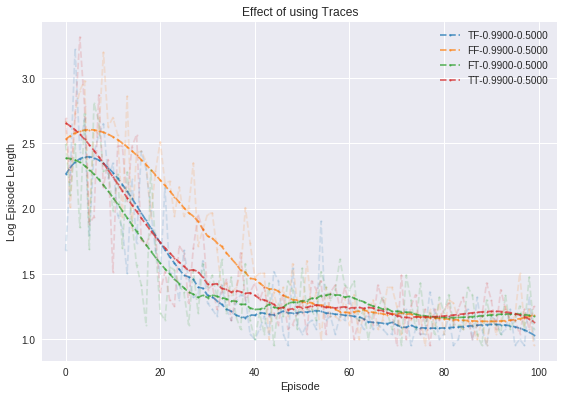

In [40]:
runTest1()

### Test 2: Effect of gamma

Five gamma values were tested with other configuration values fixed. As can be seen from the plot below, a discounting factor less than 0.99 starts to fail to converge. Compared with the performance of using 0.999 and 0.9999, converging in 30 episodes, the agent using gamma=0.99 learns much slower, converging in 95 episodes.  

In [0]:
# test 2
def runTest2():
    """
    this test compares different values of gamma
    """
    test_name = "Effect of using different values of gamma"

    num_episodes_per_test = 100

    lambda_trace = 0.5

    # see TestConfig class for how to change test configurations
    # NOTE: small gammas do not allow to converge
    gammas = [0.9, 0.95, 0.99, 0.999, 0.9999]
    configurations = [TestConfig(True, True, gamma, lambda_trace) for gamma in gammas]

    # run tests and plot results
    stats_dict = runMultiTests(num_episodes_per_test, configurations)
    plotstats(test_name, stats_dict, num_episodes_per_test)

Running tests with configuration: TT-0.900000-0.500000
Step 180 @ Episode 100/100 (1.0)
Running tests with configuration: TT-0.950000-0.500000
Step 460 @ Episode 90/100 (1.0)

Step 180 @ Episode 100/100 (1.0)
Running tests with configuration: TT-0.990000-0.500000
Step 40 @ Episode 100/100 (1.0)
Running tests with configuration: TT-0.999000-0.500000
Step 20 @ Episode 100/100 (1.0)
Running tests with configuration: TT-0.999900-0.500000
Step 30 @ Episode 100/100 (1.0)
Plotting results; smoothed with 51-wide savgol filter.


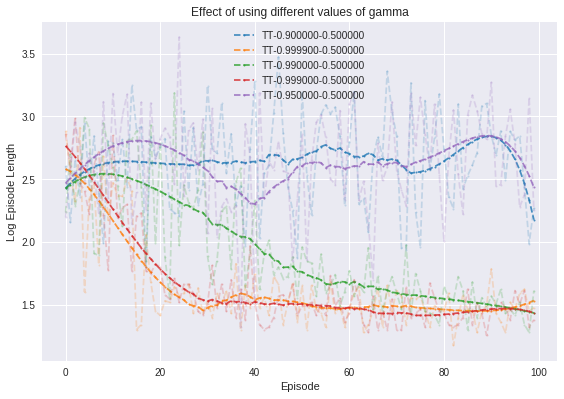

In [61]:
runTest2()

### Test 3: Effect of lambda

Six different lambda values ranging from 0.01 to 0.9 were tested with gamma=0.999 and both traces turn on. The episode length during training can be seen in the figure below. Note that the plot contains both the actual data plot and a smoothened plot. When the value of lambda is too high (e.g. 0.75, 0.9), eligibility trace causes the algorithm to diverge dramatically after around 10 episodes. We set episode maximum number of steps to 10k, so most of the diverging episodes were killed at 10k steps before it gets to finish. Lambda value less than 0.5 converges similarly fast. The optimal value for lambda is about 0.25.

In [0]:
def runTest3():
    """
    this test compares different values of lambda
    """
    test_name = "Effect of using Traces"

    num_episodes_per_test = 100

    gamma = 0.999

    # see TestConfig class for how to change test configurations
    # NOTE: small gammas do not allow to converge
    lambdas = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9]
    configurations = [TestConfig(True, True, gamma, lambda_trace) for lambda_trace in lambdas]

    # run tests and plot results
    stats_dict = runMultiTests(num_episodes_per_test, configurations)
    plotstats(test_name, stats_dict, num_episodes_per_test)

Running tests with configuration: TT-0.999000-0.10000
Step 20 @ Episode 100/100 (1.0)
Running tests with configuration: TT-0.999000-0.100000
Step 10 @ Episode 100/100 (1.0)
Running tests with configuration: TT-0.999000-0.250000
Step 20 @ Episode 100/100 (1.0)
Running tests with configuration: TT-0.999000-0.500000
Step 30 @ Episode 100/100 (1.0)
Running tests with configuration: TT-0.999000-0.750000
Step 2010 @ Episode 12/100 (1.0)

Step 10000 @ Episode 100/100 (0.0)
Running tests with configuration: TT-0.999000-0.900000


Step 10000 @ Episode 100/100 (0.0)
Plotting results; smoothed with 51-wide savgol filter.


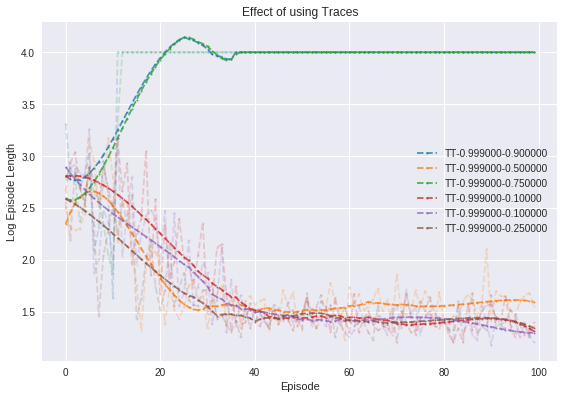

In [63]:
runTest3()

## Conclusion 

Actor-Critic is a simple and efficient policy gradient method and eligibility traces boost its performance. When using a bootstrapping critic (e.g. TD(0)), Actor-Critic becomes fully online and takes the advantages of bootstrapping which makes the learning even faster. 

This lab have done 3 tests on the effect of eligibility traces, the discounting factor gamma, and the trace-decay rate lambda. 
* Turning on either or both eligibility traces for actor and critic helps the algorithm achieve similar good learning rate and all converges much faster than not using any traces. 
* Discounting factor gamma turned to be very sensitive based on test 2 (in 0.001 scale). Using gamma values of 0.999 and 0.9999 converges much faster than using 0.99, while smaller values of gamma prevent convergence (<0.95). 
* Trace-decay rate should be small. In test 3, the optimal performance achieved at around 0.25. The value of lambda should not be larger than 0.5 to converge. 
